# **Dobra, jakis tytul trzeba tu wymyślić** #

## **1. Basic imports** ##

In [ ]:
import numpy as np
import pandas as pd
from enum import Enum
from abc import ABC, abstractmethod
from statistics import mean, median, stdev

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy.stats import ks_2samp, wasserstein_distance, spearmanr, anderson_ksamp
from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon

from scipy.spatial.distance import cdist
from pyclustering.cluster.xmeans import xmeans, kmeans_plusplus_initializer # type: ignore

from river.datasets import synth
from river.drift import ADWIN
from river import evaluate, metrics, ensemble, drift, tree

import matplotlib.pyplot as plt

## **2. Creating concept drift stream** ##

### **2.1. Different Concept Drift Generators** ###

#### **2.1.1. SEA** ####

Ten generator jest fajny, ale trzeba zmienić variant zeby były rózne. Inaczej wygeneują się dwa niemal identyczne strumienie.

In [2]:
stream_SEA = synth.ConceptDriftStream(
    stream=synth.SEA(seed=42, variant=0),
    drift_stream=synth.SEA(seed=42, variant=3),
    position=500,
    width=10,
    seed=1
)

#### **2.1.2. Hyperplane** ####

In [3]:
stream_Hyperplane = synth.ConceptDriftStream(
    stream=synth.Hyperplane(n_features=2, seed=42),
    drift_stream=synth.Hyperplane(n_features=2, seed=42),
    position=500,
    width=100,
    seed=1
)

In [4]:
stream_Hyperplane = synth.Hyperplane(
    n_features=2,
    noise_percentage=0.0,
    mag_change=0.01,
    seed=42
)

#### **2.1.3. RandomRBF** ####

To jest trochę crazy i coś tam coś tam ze jakies centroidy, ale nie wygląda to tak ładnie jak SEA

In [5]:
stream_RBF = synth.ConceptDriftStream(
    stream=synth.RandomRBF(n_features=2),
    drift_stream=synth.RandomRBF(n_features=2),
    position=500,
    width=10,
    seed=1
)

### **2.2. Visualization of data drift** ###

In [6]:
def visualize_drift(stream, n):
    """
    Visualizes the data points before and after a concept drift in a 2D feature space.

    Parameters:
    - stream: A data stream object that yields (features, label) tuples.
    - n: Total number of samples to take from the stream for visualization. Drift starts at n/2.
    """
    X, y = [], []
    for x, label in stream.take(n):
        X.append(x)
        y.append(label)

    # Convert to lists of features
    f1 = [row[0] for row in X]
    f2 = [row[1] for row in X]

    # Plot before and after drift
    plt.figure(figsize=(12, 5))

    # Before drift
    plt.subplot(1, 2, 1)
    plt.scatter(f1[:n//2], f2[:n//2], c=y[:n//2], cmap="coolwarm", s=20, alpha=0.7)
    plt.title("Before Drift")
    plt.xlabel("att0")
    plt.ylabel("att1")

    # After drift
    plt.subplot(1, 2, 2)
    plt.scatter(f1[n//2:], f2[n//2:], c=y[n//2:], cmap="coolwarm", s=20, alpha=0.7)
    plt.title("After Drift")
    plt.xlabel("att0")
    plt.ylabel("att1")

    plt.tight_layout()
    plt.show()

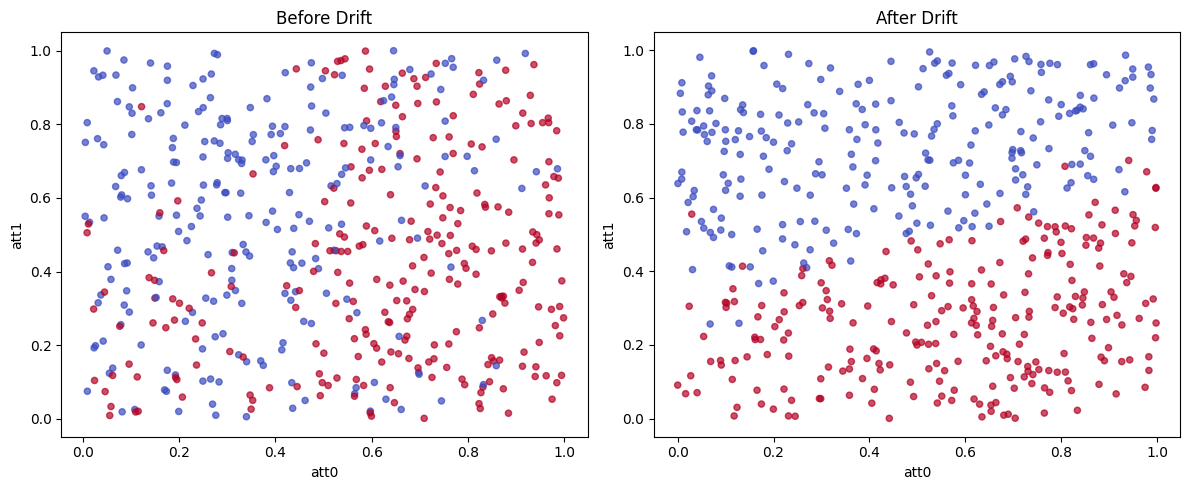

In [7]:
visualize_drift(stream_Hyperplane, 1000)

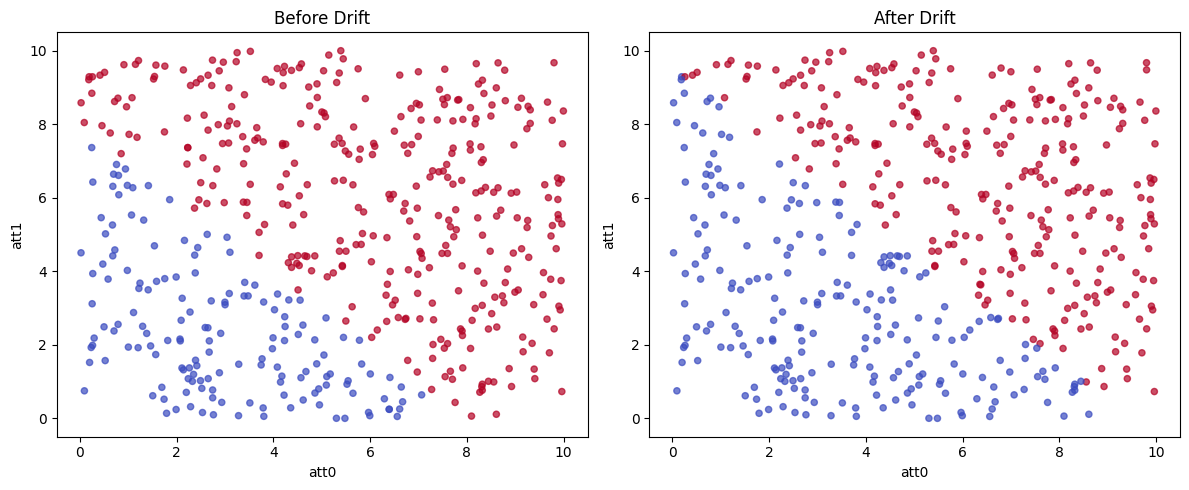

In [8]:
visualize_drift(stream_SEA, 1000)

## **3. Data scaling**

### **3.1. Data normalization** ##

May be necessary later

In [182]:
class ScalingType(Enum):
    MinMax = 'min_max'
    Standardization = 'standardization'

def transform_dict_to_list(stream):
    X, y = [], []
    for x, label in stream.take(1000):
        X.append(list(x.values()))
        y.append(label)
    return X, y

class DataScaler:
    def __init__(self, scaling_type):
        if scaling_type==ScalingType.MinMax:
            self.scaler = MinMaxScaler()
        elif scaling_type==ScalingType.Standardization:
            self.scaler = StandardScaler()
        else:
            raise ValueError("Unsupported scaling type")

    def fit(self, X):
        X_df = pd.DataFrame(X)
        self.scaler.fit(X_df)
        
    def transform(self, X): # one scaler can be fitted once but used many times
        X_df = pd.DataFrame(X)
        return self.scaler.transform(X_df)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [36]:
X, y = transform_dict_to_list(stream_SEA)
X_before, X_after = X[:500], X[500:]
y_before, y_after = y[:500], y[500:]

data_scaler = DataScaler(ScalingType.Standardization)
X_before_scaled = data_scaler.fit_transform(X_before)
X_after_scaled = data_scaler.transform(X_after)

## **4. Drift detection using descriptive statistics**

In [134]:
class StatisticsType(Enum):
    Mean = 'mean'
    StandardDeviation = 'sd'
    Min = 'min'
    Max = 'max'
    Median = 'median'
    ImbalanceRatio = 'imbalance_ratio'

class DriftDetector(ABC):
    def detect(self):
        pass

class DescriptiveStatisticsDriftDetector(DriftDetector):
    def __init__(self):
        pass

    def calculate_range(self, old_value, new_value, thr):
        if old_value == 0 and new_value == 0:
            return False
        elif old_value == 0 and new_value != 0:
            return True
        elif abs(new_value - old_value)/abs(old_value) > thr:
            return True
        return False

    def detect_mean(self, old_data, new_data, thr):
        old_mean = old_data.groupby('label').mean().T
        new_mean = new_data.groupby('label').mean().T

        assert old_mean.shape == new_mean.shape
        for label in old_mean.columns:
            for feature in old_mean.index:
                if self.calculate_range(old_mean.at[feature, label], new_mean.at[feature, label], thr):
                    return True
        return False

    def detect_median(self, old_series, new_series, thr):
        old_median = old_series.groupby('label').median().T
        new_median = new_series.groupby('label').median().T
        
        assert old_median.shape == new_median.shape
        for label in old_median.columns:
            for feature in old_median.index:
                if self.calculate_range(old_median.at[feature, label], new_median.at[feature, label], thr):
                    return True
        return False

    def detect_sd(self, old_data, new_data, thr):
        old_sd = old_data.groupby('label').std().T
        new_sd = new_data.groupby('label').std().T

        assert old_sd.shape == new_sd.shape
        for label in old_sd.columns:
            for feature in old_sd.index:
                if self.calculate_range(old_sd.at[feature, label], old_sd.at[feature, label], thr):
                    return True
        return False

    def detect_min(self, old_data, new_data, thr):
        old_min = old_data.groupby('label').min().T
        new_min = new_data.groupby('label').min().T
        
        assert old_min.shape == new_min.shape
        for label in old_min.columns:
            for feature in old_min.index:
                if self.calculate_range(old_min.at[feature, label], new_min.at[feature, label], thr):
                    return True
        return False

    def detect_max(self, old_data, new_data, thr):
        old_max = old_data.groupby('label').max().T
        new_max = new_data.groupby('label').max().T
        
        assert old_max.shape == new_max.shape
        for label in old_max.columns:
            for feature in old_max.index:
                if self.calculate_range(old_max.at[feature, label], new_max.at[feature, label], thr):
                    return True
        return False
    
    def detect_imbalance_ratio(self, old_data, new_data, thr):
        old_ir = old_data['label'].value_counts(normalize=True)
        new_ir = new_data['label'].value_counts(normalize=True)

        assert old_ir.shape == new_ir.shape
        for label in old_ir.index:
            if self.calculate_range(old_ir.at[label], new_ir.at[label], thr):
                return True
        return False

    def detect(self, old_data, new_data, stat_type, features=None, thr=0.2):
        if features is not None:
            old_data = old_data[features]
            new_data = new_data[features]

        if stat_type == StatisticsType.Mean:
            return self.detect_mean(old_data, new_data, thr)
        elif stat_type == StatisticsType.StandardDeviation:
            return self.detect_sd(old_data, new_data, thr)
        elif stat_type == StatisticsType.Min:
            return self.detect_min(old_data, new_data, thr)
        elif stat_type == StatisticsType.Max:
            return self.detect_max(old_data, new_data, thr)
        elif stat_type == StatisticsType.Median:
            return self.detect_median(old_data, new_data, thr)
        elif stat_type == StatisticsType.ImbalanceRatio:
            return self.detect_imbalance_ratio(old_data, new_data, thr)
        else:
            raise ValueError("Unsupported statistics type")

In [135]:
def transform_lists_to_df(X, y):
    X_df = pd.DataFrame(X)
    y_series = pd.Series(y)
    data = pd.concat([X_df, y_series], axis=1)
    data.columns = [f'feature{i}' for i in range(X_df.shape[1])] + ['label']
    return data

In [136]:
data_before = transform_lists_to_df(X_before, y_before)
data_after = transform_lists_to_df(X_after, y_after)

DSDD = DescriptiveStatisticsDriftDetector()
print(DSDD.detect(data_before, data_after, StatisticsType.Mean))
print(DSDD.detect(data_before, data_after, StatisticsType.Min))
print(DSDD.detect(data_before, data_after, StatisticsType.Max))
print(DSDD.detect(data_before, data_after, StatisticsType.Median))
print(DSDD.detect(data_before, data_after, StatisticsType.StandardDeviation))
print(DSDD.detect(data_before, data_after, StatisticsType.ImbalanceRatio))

True
True
True
False
False
True


## **5. Drift detection using statistical tests**

In [179]:
class StatisticalTestType(Enum):
    KolmogorovSmirnov = 'kolmogorov_smirnov_test'
    KullbackLeibler = 'kullback_leibler_divergence'
    WassersteinDistance = 'wasserstein_distance'
    JensenShannon = 'jensen_shannon_divergence'
    Spearman = 'spearman_correlation_coefficient'
    AD = 'ad'
    CHI2 = 'chi2'

class StatisticalTestsDriftDetector(DriftDetector):
    def __init__(self):
        pass

    def detect_kolmogorov_smirnov(self, old_data, new_data, alpha=0.05):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                stat, p_value = ks_2samp(old_data[old_data.label == l][column], new_data[new_data.label == l][column])
                if p_value < alpha:
                    return True
        return False

    def detect_kullback_leibler(self, old_data, new_data, thr=0.1, bins=30):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                old_dist = np.histogram(old_data[old_data.label == l][column], bins=bins, density=True)[0] + 1e-10
                new_dist = np.histogram(new_data[new_data.label == l][column], bins=bins, density=True)[0] + 1e-10

                old_dist /= old_dist.sum()
                new_dist /= new_dist.sum()

                kl_div = sum(rel_entr(old_dist, new_dist))
                if kl_div > thr:
                    # print("Drift detected in feature {} and label {}".format(column, l))
                    return True
        return False

    def detect_wasserstein(self, old_data, new_data, thr=0.1):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                wd = wasserstein_distance(old_data[old_data.label==l][column], new_data[new_data.label==l][column])
                if wd > thr:
                    return True
        return False

    def detect_jensen_shannon(self, old_data, new_data, thr=0.1):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                old_dist = np.histogram(old_data[old_data.label==l][column], bins=30, density=True)[0] + 1e-10
                new_dist = np.histogram(new_data[new_data.label==l][column], bins=30, density=True)[0] + 1e-10
                js_div = jensenshannon(old_dist, new_dist)
                if js_div > thr:
                    return True
        return False

    def detect_spearman(self, old_data, new_data, thr=0.5):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue      
                min_len = min(len(old_data[old_data.label==l][column]), len(new_data[new_data.label==l][column])) # sizes of distribution must be the same
                old_sample = old_data[old_data.label==l][column].sample(min_len, random_state=42)
                new_sample = new_data[new_data.label==l][column].sample(min_len, random_state=42)

                corr, _ = spearmanr(old_sample, new_sample)
                if abs(corr) < thr:
                    return True
        return False

    def detect_ad(self, old_data, new_data, alpha=0.05):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                stat, critical, sig = anderson_ksamp([old_data[old_data.label==l][column], new_data[new_data.label==l][column]])
                if sig < alpha:
                    return True
        return False

In [180]:
STDD = StatisticalTestsDriftDetector()
print(STDD.detect_kolmogorov_smirnov(data_before, data_after))
print(STDD.detect_kullback_leibler(data_before, data_after))
print(STDD.detect_wasserstein(data_before, data_after))
print(STDD.detect_jensen_shannon(data_before, data_after))
print(STDD.detect_spearman(data_before, data_after))
print(STDD.detect_ad(data_before, data_after))

False
True
True
True
True
True


## **6. Drift detection using Feature importance** ##

In [ ]:
# TODO: Michal

## **7. Model training and drift detection with ADWIN** ##

In [183]:
# TODO

In [19]:
n = 1000
X, y = [], []

for x, label in stream_SEA.take(n):
    X.append([x[i] for i in x.keys()])
    y.append(label)

Drift detected at sample 991


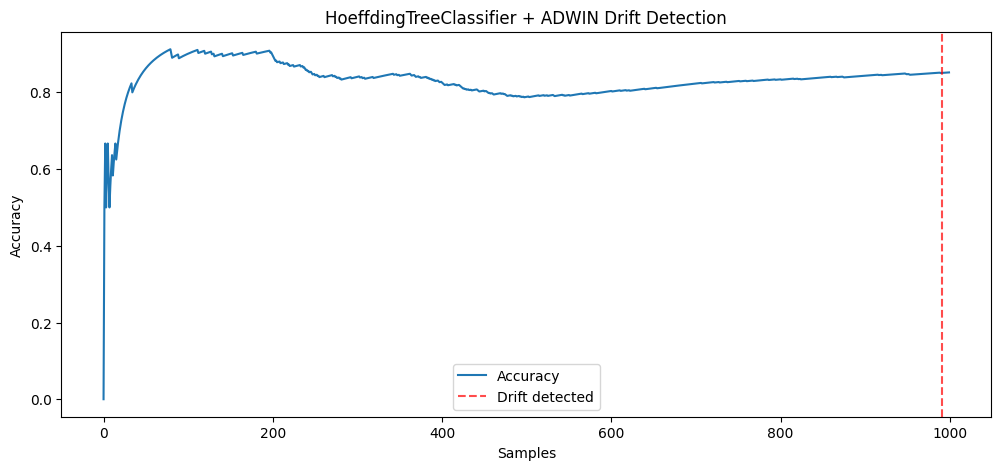

In [15]:
adwin = ADWIN()
model = tree.HoeffdingTreeClassifier()
metric = metrics.Accuracy()

accuracies = []
drift_points = []

for i, (x, y) in enumerate(stream_Hyperplane.take(n)):
    y_pred = model.predict_one(x)
    model.learn_one(x, y)

    metric.update(y, y_pred)
    accuracies.append(metric.get())

    error = int(y_pred is not None and y != y_pred)
    adwin.update(error)

    if adwin.drift_detected:
        drift_points.append(i)
        print(f"Drift detected at sample {i}")

# 6. Plot results
plt.figure(figsize=(12,5))
plt.plot(accuracies, label="Accuracy")
for dp in drift_points:
    plt.axvline(dp, color="red", linestyle="--", alpha=0.7, label="Drift detected" if dp == drift_points[0] else "")
plt.xlabel("Samples")
plt.ylabel("Accuracy")
plt.title("HoeffdingTreeClassifier + ADWIN Drift Detection")
plt.legend()
plt.show()

To jest tak na szybko robione. Trzeba tak zrobic zeby dzialalo tez dla SEA

## **7. DDM**

In [ ]:
# TODO Deniz

## **8. Clustering**

Cluster data before and after the drift. When desc statistics in corresponding clusters differ - detect drift

In [ ]:
def cluste(X, n_clusters=3):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)
    return clusters

def describe_clusters(X, clusters):
    df = pd.DataFrame(X)
    df['cluster'] = clusters
    desc = df.groupby('cluster').describe()
    return desc

def plot_clusters(X, clusters):
    plt.figure(figsize=(8,6))
    plt.scatter(X[:,0], X[:,1], c=clusters, cmap='viridis', s=30)
    plt.title("Clusters")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

def detect_drift_in_clusters(desc_before, desc_after, thr=0.2):
    for cluster in desc_before.index:
        if cluster not in desc_after.index:
            return True
        for feature in desc_before.columns.levels[0]:
            if feature == 'count':
                continue
            old_mean = desc_before.loc[cluster, (feature, 'mean')]
            new_mean = desc_after.loc[cluster, (feature, 'mean')]
            if abs(new_mean - old_mean)/abs(old_mean) > thr:
                return True
    return False

class ClusterBasedDriftDetector(DriftDetector):
    def __init__(self):
        pass

    def _xmeans(self, X, k_init=2, k_max=10):
        init_centers = kmeans_plusplus_initializer(X, k_init).initialize()
        xm = xmeans(X, init_centers, kmax=k_max)
        xm.process()
        centers = np.array(xm.get_centers())
        return centers

    def detect(self, X_old, X_new, k_init=2, k_max=10, thr_clusters=1, thr_centroid_shift=0.5):
        centers_old = self.run_xmeans(X_old, k_init, k_max)
        centers_new = self.run_xmeans(X_new, k_init, k_max)

        n_old, n_new = len(centers_old), len(centers_new)
        drift = False
        details = {}

        # Check change in number of clusters
        details['n_clusters_old'] = n_old
        details['n_clusters_new'] = n_new
        if abs(n_old - n_new) >= thr_clusters:
            details['cluster_change_flag'] = True
            drift = True
        else:
            details['cluster_change_flag'] = False

        # Compute centroid shift (average minimal pairwise distance)
        dist_matrix = cdist(centers_old, centers_new)
        min_dists = np.min(dist_matrix, axis=1)
        avg_shift = np.mean(min_dists)
        details['avg_centroid_shift'] = avg_shift

        if avg_shift > thr_centroid_shift:
            details['centroid_shift_flag'] = True
            drift = True
        else:
            details['centroid_shift_flag'] = False

        details['drift_detected'] = drift
        return drift, details
    
    def describe_clusters(self, X, clusters):
        pass

    def plot_clusters(self, X, clusters):
        pass 

    def plot_drift(self):
        pass

## **9. Prototypes**

In [ ]:
# TODO: Deniz/Michal

## **10. Decision boundary**

In [ ]:
# TODO: Wojtek